# DSA4262 Assignment 2

GitHub Repo: <https://github.com/ginnielee/DSA4262/tree/main/Assignment%202>

To reproduce: install requirements, place data in /data, run notebook top-to-bottom.

## Importing packages


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import re
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from pathlib import Path
import random


## Dataload and Overview

### Set Seed

In [2]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

### Data Structure and Columns

In [3]:
# load Dreaddit training dataset 
# Expected file locations:
# data/dreaddit-train.csv
# data/dreaddit-test.csv

DATA_DIR = Path("data")

train_path = DATA_DIR / "dreaddit-train.csv"
test_path  = DATA_DIR / "dreaddit-test.csv"
train = pd.read_csv(train_path)


print("Shape:", train.shape)
print("\nColumns:", train.columns.tolist())

train[["subreddit", "label", "text"]].head(5)



Shape: (2838, 116)

Columns: ['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'label', 'confidence', 'social_timestamp', 'social_karma', 'syntax_ari', 'lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout', 'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS', 'lex_liwc_Sixltr', 'lex_liwc_Dic', 'lex_liwc_function', 'lex_liwc_pronoun', 'lex_liwc_ppron', 'lex_liwc_i', 'lex_liwc_we', 'lex_liwc_you', 'lex_liwc_shehe', 'lex_liwc_they', 'lex_liwc_ipron', 'lex_liwc_article', 'lex_liwc_prep', 'lex_liwc_auxverb', 'lex_liwc_adverb', 'lex_liwc_conj', 'lex_liwc_negate', 'lex_liwc_verb', 'lex_liwc_adj', 'lex_liwc_compare', 'lex_liwc_interrog', 'lex_liwc_number', 'lex_liwc_quant', 'lex_liwc_affect', 'lex_liwc_posemo', 'lex_liwc_negemo', 'lex_liwc_anx', 'lex_liwc_anger', 'lex_liwc_sad', 'lex_liwc_social', 'lex_liwc_family', 'lex_liwc_friend', 'lex_liwc_female', 'lex_liwc_male', 'lex_liwc_cogproc', 'lex_liwc_insight', 'lex_liwc_cause', 'lex_liwc_discrep', 'lex_liwc_tentat', 'lex_liwc_certain', 

,subreddit,label,text
0,ptsd,1,"He said he had not felt that way before, sugge..."
1,assistance,0,"Hey there r/assistance, Not sure if this is th..."
2,ptsd,1,My mom then hit me with the newspaper and it s...
3,relationships,1,"until i met my new boyfriend, he is amazing, h..."
4,survivorsofabuse,1,October is Domestic Violence Awareness Month a...


### Checking for errors and missing information

In [4]:
# Check missing values in key columns
print("Missing text:", train["text"].isna().sum())
print("Missing label:", train["label"].isna().sum())
print("Missing subreddit:", train["subreddit"].isna().sum())


Missing text: 0
Missing label: 0
Missing subreddit: 0


## Exploratory Data Analysis

### Label Distributions

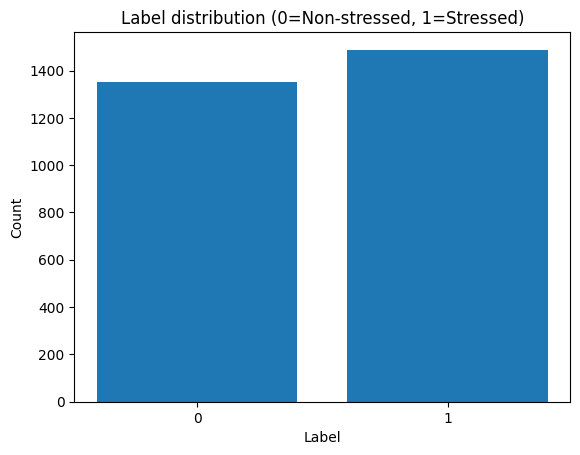

In [5]:
# 2.1 Label distribution
label_counts = train["label"].value_counts().sort_index()
plt.figure()
plt.bar(label_counts.index.astype(str), label_counts.values) # type: ignore
plt.title("Label distribution (0=Non-stressed, 1=Stressed)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


The dataset is fairly balanced between classes, with slightly more stressed (1) than non-stressed (0) posts (roughly ~1.5k vs ~1.35k from the plot). This reduces the risk of extreme class imbalance, but performance can still differ by community and text style, so I will evaluate using F1-score and use stratified splits/CV to preserve label proportions.

### Number of Posts Per Subreddit

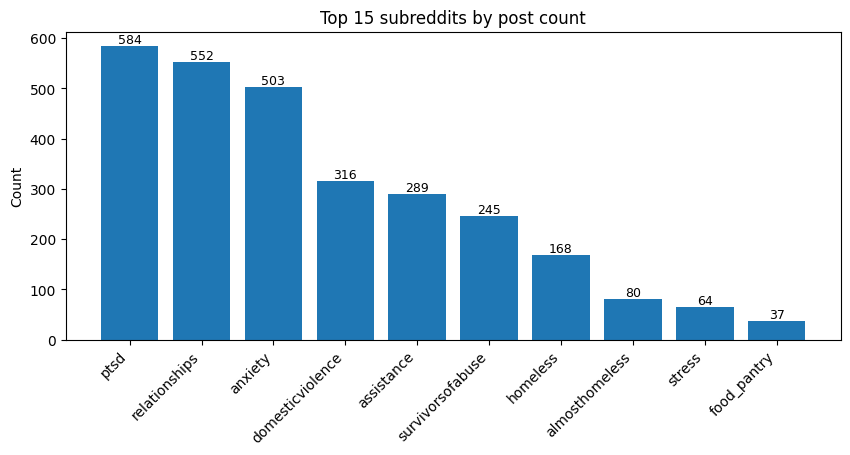

In [6]:
# 2.2 Subreddit distribution (top 15)
sub_counts = train["subreddit"].value_counts().head(15)
plt.figure(figsize=(10,4))

# ensure types are numpy/native types to satisfy type checkers
x = sub_counts.index.astype(str)
heights = sub_counts.to_numpy(dtype=int)

bars = plt.bar(x, heights)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=9)

plt.title("Top 15 subreddits by post count")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.show()


Post counts are uneven across subreddits. The largest communities are r/ptsd (~584), r/relationships (~552), and r/anxiety (~503), while smaller ones include r/almosthomeless (~80), r/stress (~64), and r/food_pantry (37). This matters because models trained on this dataset may implicitly learn patterns dominated by the largest communities, and any subreddit-level metric (F1 / FP / FN) will be less stable for small-n subreddits. Later, small-n results will be interpreted cautiously when we focus on cross-community generalisation (A1) to quantify domain shift.

### Post Length Analysis

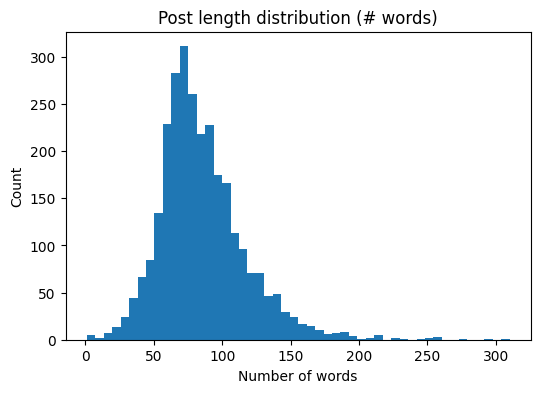

In [7]:
# 2.3 Post length distribution (words)
train["n_words"] = train["text"].astype(str).apply(lambda s: len(s.split()))

plt.figure(figsize=(6,4))
plt.hist(train["n_words"], bins=50)
plt.title("Post length distribution (# words)")
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.show()

Post lengths are concentrated around ~60–100 words, with a clear right tail extending past 200 words and up to ~300+ words. This indicates many posts are short-to-medium, but a non-trivial portion are long narratives. Length can correlate with “amount of context,” and may act as a shortcut feature (e.g., long narrative posts may be easier/harder depending on the model).

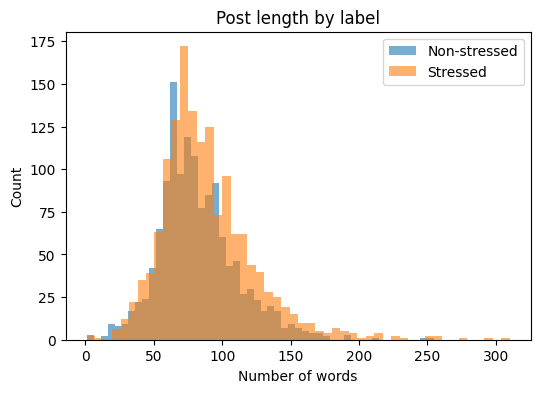

In [8]:
# Compare length by label
plt.figure(figsize=(6,4))
plt.hist(train.loc[train["label"]==0, "n_words"], bins=50, alpha=0.6, label="Non-stressed")
plt.hist(train.loc[train["label"]==1, "n_words"], bins=50, alpha=0.6, label="Stressed")
plt.title("Post length by label")
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.legend()
plt.show()

The stressed and non-stressed distributions overlap heavily, but stressed posts appear slightly more represented in the longer tail (more stressed examples above ~120–150 words). This suggests stress detection might partially correlate with narrative elaboration or contextual detail rather than only explicit stress keywords. This will be useful later when interpreting failure modes: models may struggle with long, context-dependent narratives (missed indirect distress) or over-flag emotionally intense long posts.

## Preprocessing 

### Changing all text to lowercase for standardisation

In [9]:
def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)   # remove URLs
    s = re.sub(r"\s+", " ", s).strip()        # collapse whitespace
    return s


train["text_clean"] = train["text"].apply(clean_text)
X_text = train["text_clean"]
y = train["label"].astype(int)
train[["text", "text_clean"]].head(3)


,text,text_clean
0,"He said he had not felt that way before, sugge...","he said he had not felt that way before, sugge..."
1,"Hey there r/assistance, Not sure if this is th...","hey there r/assistance, not sure if this is th..."
2,My mom then hit me with the newspaper and it s...,my mom then hit me with the newspaper and it s...


### Converting numeric feature columns to numeric data types

In [10]:
TEXT_COL = "text_clean"   # use your cleaned text column
LABEL_COL = "label"
GROUP_COL = "subreddit"
# Exclude columns that should not be model inputs
exclude = {"label", "text", "text_clean", "subreddit", "post_id", "id", "sentence_range"}

# Exclude social_* (platform reaction signals) to focus on text-based features
exclude |= {c for c in train.columns if c.startswith("social_")}

candidate_cols = [c for c in train.columns if c not in exclude]

# force candidates to numeric if possible; non-numeric becomes NaN
for c in candidate_cols:
    train[c] = pd.to_numeric(train[c], errors="coerce")

num_cols = [c for c in candidate_cols if pd.api.types.is_numeric_dtype(train[c])]


print("Number of numeric feature columns:", len(num_cols))
num_cols[:10]


Number of numeric feature columns: 107


['confidence',
 'syntax_ari',
 'lex_liwc_WC',
 'lex_liwc_Analytic',
 'lex_liwc_Clout',
 'lex_liwc_Authentic',
 'lex_liwc_Tone',
 'lex_liwc_WPS',
 'lex_liwc_Sixltr',
 'lex_liwc_Dic']

## Model Testing


In this section, I experimented with 3 common models and utilised them on the train-validation splits to assess which has the highest F1 Score.

The 3 models in question are:

**Model 1 (TF-IDF + Logistic Regression)**

A simple, interpretable baseline that gives calibrated probabilities and clear feature weights.

**Model 2 (TF-IDF + Linear SVM)**

 A strong linear text baseline that often performs well on sparse TF-IDF features.

**Model 3 (Hybrid TF-IDF + LIWC/DAL/etc + Logistic Regression)**

 Combines lexical content with psycholinguistic signals to capture both what is said and how it is said.

These 3 models will then be evaluated with a 5-fold Cross Validation method and, the mean F1 score will be reported. Only the final model will be utilised on the test set.

### 3 Models

In [11]:
stop = list(ENGLISH_STOP_WORDS)

#### Model 1: TF-IDF + Logistic Regression

In [12]:
pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, stop_words= stop)),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
])


#### Model 2: TF-IDF + Linear SVM

In [13]:
pipe_svm = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, stop_words= stop)),
    ("clf", LinearSVC(class_weight="balanced"))
])


#### Model 3: Hybrid (TF-IDF text + numeric LIWC/DAL/syntax/sentiment) + Logistic Regression

In [14]:
preprocess_hybrid = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, stop_words=stop), TEXT_COL),
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler(with_mean=False))
        ]), num_cols)
    ],
    remainder="drop"
)

pipe_hybrid = Pipeline([
    ("prep", preprocess_hybrid),
    ("clf", LogisticRegression(max_iter=4000, class_weight="balanced"))
])


### Comparing models with 5-Fold Cross Validation

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_f1(model, X, y):
    scores = cross_val_score(model, X, y, scoring="f1", cv=cv, n_jobs=-1)
    return scores.mean(), scores.std()

results = []
for name, model, X in [
    ("TFIDF + Logistic Regression", pipe_lr, X_text),
    ("TFIDF + LinearSVC",         pipe_svm, X_text),
    ("Hybrid (TFIDF + numeric) + Logistic Regression",  pipe_hybrid, train),
]:
    mean_f1, std_f1 = cv_f1(model, X, y)
    results.append((name, mean_f1, std_f1))

pd.DataFrame(results, columns=["model", "cv_f1_mean", "cv_f1_std"]).sort_values("cv_f1_mean", ascending=True)


,model,cv_f1_mean,cv_f1_std
1,TFIDF + LinearSVC,0.738352,0.009904
0,TFIDF + Logistic Regression,0.750046,0.015594
2,Hybrid (TFIDF + numeric) + Logistic Regression,0.776326,0.014813


### Results and Model Selection

**Model 3: The hybrid model** achieved the highest mean CV F1 (0.776 ± 0.0148), outperforming both text-only baselines.

This suggests the precomputed LIWC/sentiment/syntax features add complementary signal beyond raw n-grams, likely capturing psychological cues such as emotion/affect and self-focus that are not purely topic words. Differences are modest, so a model that supports later analysis and deployment considerations is prioritised.

The hybrid model is selected as the final model for further analyses and test evaluation, because it provides the best overall predictive performance while still remaining relatively interpretable (linear model weights) compared to deep models.

### Hyperparameter tuning

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Make LR more likely to converge
pipe_hybrid.set_params(clf__max_iter=8000)

param_grid = {
    "prep__text__ngram_range": [(1,2)],             # keep best default
    "prep__text__max_features": [60000],            # try just 1 first
    "clf__C": [0.3, 1, 3]                           # small set
}

grid = GridSearchCV(pipe_hybrid, param_grid, scoring="f1", cv=cv, n_jobs=-1, verbose=2)

X_hybrid = train[["text_clean"] + num_cols]
y = train["label"].astype(int)

grid.fit(X_hybrid, y)


print("Best CV F1 Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))
best_hybrid = grid.best_estimator_


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END clf__C=0.3, prep__text__max_features=60000, prep__text__ngram_range=(1, 2); total time=   5.5s
[CV] END clf__C=0.3, prep__text__max_features=60000, prep__text__ngram_range=(1, 2); total time=   6.1s
[CV] END clf__C=0.3, prep__text__max_features=60000, prep__text__ngram_range=(1, 2); total time=   6.5s
[CV] END clf__C=0.3, prep__text__max_features=60000, prep__text__ngram_range=(1, 2); total time=   6.9s
[CV] END clf__C=1, prep__text__max_features=60000, prep__text__ngram_range=(1, 2); total time=   8.5s
[CV] END clf__C=0.3, prep__text__max_features=60000, prep__text__ngram_range=(1, 2); total time=   5.9s
[CV] END clf__C=1, prep__text__max_features=60000, prep__text__ngram_range=(1, 2); total time=  10.7s
[CV] END clf__C=1, prep__text__max_features=60000, prep__text__ngram_range=(1, 2); total time=  12.4s
[CV] END clf__C=1, prep__text__max_features=60000, prep__text__ngram_range=(1, 2); total time=   9.1s
[CV] END clf

A small hyperparameter search improved mean CV F1 from 0.776 to 0.779; Tuning stops here due to diminishing returns.

## Using Test Data on Final Model

We use the test set only once after selecting the model to avoid leakage.

### Cleaning Test Data

In [17]:
test_path  = DATA_DIR / "dreaddit-test.csv"
test = pd.read_csv(test_path)
test["text_clean"] = test["text"].apply(clean_text)

### Test Evaluation

In [18]:
X_train_hybrid = train[["text_clean"] + num_cols].copy()
y_train = train["label"].astype(int).copy()

for c in num_cols:
    if c not in test.columns:
        test[c] = np.nan

# Coerce numeric cols to numeric (non-numeric becomes NaN)
for c in num_cols:
    test[c] = pd.to_numeric(test[c], errors="coerce")

X_test_hybrid = test[["text_clean"] + num_cols].copy()

best_hybrid.fit(X_train_hybrid, y_train)

test_pred = best_hybrid.predict(X_test_hybrid)
y_test = test["label"].astype(int)

print("Test F1:", f1_score(y_test, test_pred))
print(classification_report(y_test, test_pred))
print(confusion_matrix(y_test, test_pred))

Test F1: 0.7547169811320755
              precision    recall  f1-score   support

           0       0.74      0.73      0.74       346
           1       0.75      0.76      0.75       369

    accuracy                           0.75       715
   macro avg       0.75      0.75      0.75       715
weighted avg       0.75      0.75      0.75       715

[[253  93]
 [ 89 280]]


From this evaluation, the F1 score, precision, and recall have an average of 0.75.

While F1 is reported, as the primary metric, precision and recall is monitored because they correspond to different deployment harms: low recall implies missed distress (false negatives), while low precision implies over-flagging and potential stigma (false positives). This motivates our subgroup FP/FN analysis in A3 and our conservative deployment stance.

## Analysis

### Analysis 1 (A1): Generalisation to Each Community

Here, each subreddit takes a turn to be treated as a test set. The model trains on the other subreddits, and a final F1 score for the test subreddit will be attained.

In [19]:
def leave_one_subr_out(best_hybrid, train_df, num_cols, min_posts=50):
    results = []
    subs = train_df[GROUP_COL].value_counts()
    subs = subs[subs >= min_posts].index.tolist()  # use subreddits with more posts, as they have more information for generalisation
    
    for sub in subs:
        tr = train_df[train_df[GROUP_COL] != sub].copy()
        te = train_df[train_df[GROUP_COL] == sub].copy()
        
        X_tr = tr[[TEXT_COL] + num_cols]
        y_tr = tr[LABEL_COL].astype(int)
        X_te = te[[TEXT_COL] + num_cols]
        y_te = te[LABEL_COL].astype(int)
        
        # fresh fit each time
        best_hybrid.fit(X_tr, y_tr)
        pred = best_hybrid.predict(X_te)
        
        results.append({
            "heldout_subreddit": sub,
            "n_test": len(te),
            "f1": f1_score(y_te, pred)
        })
        
    return pd.DataFrame(results).sort_values("f1")

loso_df = leave_one_subr_out(best_hybrid, train, num_cols, min_posts=50)
loso_df = loso_df.sort_values("f1", ascending=True)
loso_df

,heldout_subreddit,n_test,f1
4,assistance,289,0.636364
1,relationships,552,0.700611
6,homeless,168,0.701493
8,stress,64,0.761905
7,almosthomeless,80,0.769231
3,domesticviolence,316,0.780749
5,survivorsofabuse,245,0.786611
0,ptsd,584,0.791789
2,anxiety,503,0.868946


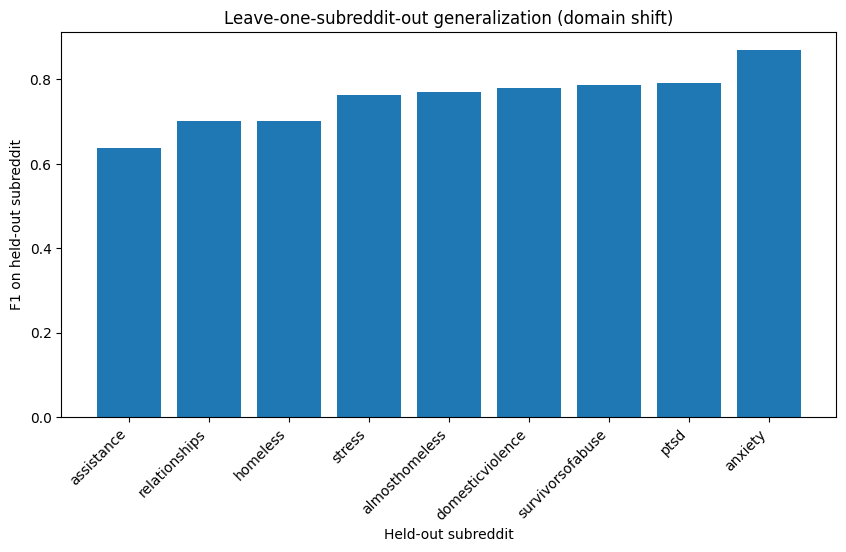

In [20]:
plt.figure(figsize=(10,5))
plt.bar(loso_df["heldout_subreddit"], loso_df["f1"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1 on held-out subreddit")
plt.xlabel("Held-out subreddit")
plt.title("Leave-one-subreddit-out generalization (domain shift)")
plt.show()

Because subreddit sample sizes are uneven (EDA), small-n communities are interpreted cautiously and pattern across larger subreddits are our focus points.

Based on the leave-one-subreddit-out evaluation, the model generalises well to **r/anxiety** (F1=0.869) but performs worse on **r/assistance** (F1=0.636), indicating community-dependent generalisation. This suggests domain shift even within Reddit: the model is not uniformly reliable across communities.

A plausible hypothesis is that communities differ in text genres (symptom disclosure vs narrative/transactional posts), which will be examined using dialect and stress markers in the next analysis.

### Analysis 2 (A2): Community Expression

Here, communities will be examined based on how posts differ through the following indicators:
- (2.1) Dialect markers that distinguish subreddit identity
- (2.2) Stress markers that distinguish stressed vs non-stressed posts within each subreddit.

#### 2.1 The Dialect Markers of Each Subreddit

In [21]:
TEXT_COL = "text_clean"
GROUP_COL = "subreddit"

def subreddit_vs_rest_dialects(df, min_posts=150, top_k=12):
    rows = []
    subs = df[GROUP_COL].value_counts()
    subs = subs[subs >= min_posts].index.tolist()

    for sub in subs:
        y = (df[GROUP_COL] == sub).astype(int)  # 1 = this subreddit
        X = df[TEXT_COL].astype(str)

        model = Pipeline([
            ("tfidf", TfidfVectorizer(
                ngram_range=(1,2),
                min_df=5,
                max_df=0.8,
                stop_words=stop
            )),
            ("clf", LogisticRegression(max_iter=4000, class_weight="balanced"))
        ])
        model.fit(X, y)

        vec = model.named_steps["tfidf"]
        clf = model.named_steps["clf"]
        feats = np.array(vec.get_feature_names_out())
        coefs = clf.coef_.ravel()

        # Get top phrases; report only bigrams for readability
        top = feats[np.argsort(coefs)[-800:]][::-1]
        top_bi = [p for p in top if " " in p][:top_k]

        rows.append({
            "subreddit": sub,
            "dialect_bigrams": ", ".join(top_bi),
            "n_posts": int((df[GROUP_COL] == sub).sum())
        })

    return pd.DataFrame(rows).sort_values("n_posts", ascending=False)

dialects = subreddit_vs_rest_dialects(train, min_posts=150, top_k=15)

with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    display(dialects)

,subreddit,dialect_bigrams,n_posts
0,ptsd,"self harm, got home, don remember, thank reading, feel guilty, 10 years, service dog, diagnosed ptsd, getting help, going happen, didn want, know need, just sick, sexual assault, ve having",584
1,relationships,"tl dr, new years, ve known, best friends, don know, like happened, bad person, grad school, things like, times day, didn want, just leave, spend time, tell just, want tell",552
2,anxiety,"panic attacks, fall asleep, hard time, video games, need help, feel free, feels like, know don, past months, heart rate, makes anxious, people don, just wanted, come home, year half",503
3,domesticviolence,"domestic violence, abusive relationship, spending time, doesn like, did wrong, don know, child support, restraining order, just like, maybe just, make work, living life, family don, guess just, relationship years",316
4,assistance,"year old, greatly appreciated, right feel, good day, time job, link url, really appreciate, ve posted, help people, little thing, free time, time read, people like, ll need, support family",289
5,survivorsofabuse,"did know, know think, just wanted, abusive relationship, having trouble, sexual abuse, isn bad, want stop, like love, believe think, started having, year old, looked like, recently moved, won able",245
6,homeless,"little money, living car, court date, social services, high school, work time, tell people, time money, family members, time posting, place sleep, didn help, old man, work just, don make",168


Using a subreddit classifier, the most discriminative bigrams are extracted based on each community. These dialect markers reflect typical topics, posting conventions and dominant terms, revealing distinct discourse genres:

- **Trauma-focused disclosure (r/ptsd)**: “self harm”, “service dog”, “diagnosed ptsd”
- **Symptom disclosure (r/anxiety)**: “panic attacks”, “heart rate”
- **Interpersonal narratives (r/relationships)**: “new years”, “best friends”, “grad school”
- **Transactional help-seeking (r/assistance)**: “greatly appreciated”, “link url”, “time read”
- **Safety/legal crisis (r/domesticviolence)**: “restraining order”, “child support”, “abusive relationship”

Examples of these dialect markers reflect clearly each community's different norms: some foreground internal symptoms, others foreground life events, requests, or crisis/legal situations. This indicates Reddit communities differ in discourse genre rather than sharing one uniform style, offering a plausible mechanism for A1’s generalisation gaps.

Furthermore, disclosure-type communities like r/anxiety and r/ptsd often encourage explicit self-disclosure of internal states, whereas subreddits that contain other forms of posts like r/assistance may show stress implicitly rather than directly. This is consistent with the hybrid feature design: LIWC-style affect and self-focus features may align more strongly with direct self-disclosure than with transactional or narrative conventions.

#### 2.2 Stress Markers within Specific Subreddits

In [22]:
TEXT_COL = "text_clean"
LABEL_COL = "label"
GROUP_COL = "subreddit"
def stress_markers_within_subreddit(df, min_posts=150, top_k=12):
    rows = []
    subs = df[GROUP_COL].value_counts()
    subs = subs[subs >= min_posts].index.tolist()

    for sub in subs:
        sub_df = df[df[GROUP_COL] == sub].copy()
        X = sub_df[TEXT_COL].astype(str)
        y = sub_df[LABEL_COL].astype(int)  # 1=stressed, 0=non-stressed

        model = Pipeline([
            ("tfidf", TfidfVectorizer(
                ngram_range=(1,2),
                min_df=3,
                max_df=0.9,
                stop_words=stop
            )),
            ("clf", LogisticRegression(max_iter=4000, class_weight="balanced"))
        ])
        model.fit(X, y)

        vec = model.named_steps["tfidf"]
        clf = model.named_steps["clf"]
        feats = np.array(vec.get_feature_names_out())
        coefs = clf.coef_.ravel()

        # stress-predictive bigrams (positive weights)
        top_pos = feats[np.argsort(coefs)[-800:]][::-1]
        stress_bi = [p for p in top_pos if " " in p][:top_k]

        # non-stress bigrams (negative weights)
        top_neg = feats[np.argsort(coefs)[:800]]
        nonstress_bi = [p for p in top_neg if " " in p][:top_k]

        rows.append({
            "subreddit": sub,
            "stress_bigrams": ", ".join(stress_bi),
            "nonstress_bigrams": ", ".join(nonstress_bi),
            "n_posts": len(sub_df),
            "stress_rate": float(sub_df[LABEL_COL].mean())
        })

    return pd.DataFrame(rows).sort_values("n_posts", ascending=False)

stress_dialects = stress_markers_within_subreddit(train, min_posts=150, top_k=12)

with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    display(stress_dialects)

,subreddit,stress_bigrams,nonstress_bigrams,n_posts,stress_rate
0,ptsd,"don know, feel like, don want, feels like, self harm, just feel, sexual abuse, don remember, ptsd ve, depression anxiety, don really, chronic pain","feel free, don just, ve started, just talk, stop talking, said wouldn, 15 years, didn really, make good, mental health, ve gone, good just",584,0.568493
1,relationships,"don know, tl dr, feel like, didn know, felt like, went home, know really, know anymore, just leave, know tell, makes feel, school boyfriend","years ago, ve met, new years, dont want, really like, couple times, want make, dr met, says doesn, doing things, let know, really want",552,0.447464
2,anxiety,"don know, feel like, panic attacks, tl dr, health anxiety, feeling like, social anxiety, just feel, need help, depression anxiety, anxiety attacks, big deal","just wanted, mental health, let know, hope help, little bit, feel free, talk doctor, things like, long time, just need, high school, just feels",503,0.658052
3,domesticviolence,"don know, feel like, don want, tl dr, treated like, feel safe, did wrong, ruin life, things like, really don, calling police, just don","make happy, year old, just like, mental health, years old, spending time, new job, started dating, maybe just, relationship years, dating woman, long distance",316,0.639241
4,assistance,"don know, make sure, save money, mental health, story short, long story, need help, ask help, feel like, really need, long time, don need","link url, help appreciated, really appreciate, thanks reading, appreciated thank, thank help, time url, help people, click link, years old, free time, let know",289,0.363322
5,survivorsofabuse,"don know, feel like, know think, want stop, just don, multiple times, don want, sexual abuse, months ago, self destructive, didn know, years old","years ago, fast forward, fell love, let know, mental health, years older, year old, support staff, 10 25, certain things, peer support, asked time",245,0.457143
6,homeless,"don know, ve homeless, services just, stay days, social services, don think, living car, year old, work time, dss social, need job, seen homeless","thanks time, people street, idea going, area told, waiting list, homeless people, sound like, tell people, decided make, mental health, just want, parking lot",168,0.375000


Stress-vs-nonstress classifiers are trained within each subreddit and the most label-discriminative bigrams are extracted. Two patterns emerge:

- Several stress-positive bigrams are still **generic distress framing** (e.g., “don’t know”, “feel like”), plausibly capturing the realistic behaviour of rumination and attempts to articulate internal state, which are common characteristics of distressed writing and can transfer across communities. 

- Each subreddit also exhibits **genre-specific stress cues** consistent with its context (e.g., "social/depression/health anxiety" in r/anxiety, "calling police" in r/domesticviolence, and "need help" in r/assistance). 

Importantly, non-stress bigrams in some communities contain strong posting conventions (e.g., “link url”, “thanks reading”, “really appreciate”), suggesting the model can partially learn community boilerplate as a shortcut for labelling texts as non-stress. This can inflate apparent performance within one community and reduce transferability in another.

Taken together, 2.1 and 2.2 suggest that cross-community performance is driven by discourse genre: communities with direct and general symptom-language align better with transferable stress cues. Narrative/transactional communities embed distress in context, making it more difficult to detect. These genre differences imply different FP/FN risks, which A3 will test on held-out errors.

### Analysis 3 (A3): Confidently Wrong Submissions

In [23]:
pred = np.asarray(best_hybrid.predict(X_test_hybrid)).ravel()

if hasattr(best_hybrid, "predict_proba"):
    prob = np.asarray(best_hybrid.predict_proba(X_test_hybrid)[:, 1]).ravel()
    test = test.assign(pred_label=pd.Series(pred, index=test.index),
                       pred_prob_stress=pd.Series(prob, index=test.index))
else:
    test = test.assign(pred_label=pd.Series(pred, index=test.index))


#### 3.1 Error profiles of Subreddits

In [24]:
def error_profile(df):
    df = df.copy()
    df["FP"] = ((df["pred_label"] == 1) & (df["label"] == 0)).astype(int)
    df["FN"] = ((df["pred_label"] == 0) & (df["label"] == 1)).astype(int)
    df["ERR"] = (df["pred_label"] != df["label"]).astype(int)
    
    prof = df.groupby("subreddit").agg(
        n=("label", "size"),
        stress_rate=("label", "mean"),
        error_rate=("ERR", "mean"),
        fp_rate=("FP", "mean"),
        fn_rate=("FN", "mean"),
    ).sort_values("error_rate", ascending=False)
    return prof

profile_df = error_profile(test)
profile_df = profile_df.sort_values("error_rate", ascending=False)
profile_df.head(10)


,n,stress_rate,error_rate,fp_rate,fn_rate
subreddit,,,,,
almosthomeless,19,0.631579,0.368421,0.105263,0.263158
relationships,142,0.422535,0.316901,0.140845,0.176056
survivorsofabuse,70,0.442857,0.285714,0.171429,0.114286
ptsd,127,0.645669,0.267717,0.118110,0.149606
domesticviolence,72,0.652778,0.236111,0.083333,0.152778
homeless,52,0.346154,0.230769,0.115385,0.115385
anxiety,147,0.578231,0.204082,0.136054,0.068027
assistance,66,0.318182,0.181818,0.090909,0.090909
food_pantry,6,0.500000,0.166667,0.000000,0.166667


Note: Only communities with n≥50 are mainly interpreted; smaller subreddits are illustrative but unstable

The subreddit-level error table shows that model reliability is community-dependent. For example, r/relationships has a stress prevalence of 0.423 (42.3% of posts labelled stressed) but also the highest overall error rate (0.324), indicating this is the least reliable community for the model. Errors in r/relationships are also skewed toward FNs (fn_rate = 0.176), meaning roughly 1 in 5 posts are labelled stressed but predicted as non-stressed—an important failure mode because it corresponds to “missed distress.”

Error profiles vary across communities. Some subreddits show relatively higher FP rates than FN rates (e.g., r/anxiety, r/survivorsofabuse), implying a greater risk of over-flagging. Others (e.g., r/ptsd, r/domesticviolence) show FN ≥ FP, suggesting under-detection may be the dominant risk. Overall, the table suggests that the type of harm (over-flagging vs missed detection) depends on the community’s discourse.


#### 3.2 Deep Dive into r/relationships “Confident Wrong” Cases

In [25]:
def confident_wrong_examples(df, subreddit, k=3):
    sub = df[df["subreddit"] == subreddit].copy()
    fp = sub[(sub["label"]==0) & (sub["pred_label"]==1)]
    fn = sub[(sub["label"]==1) & (sub["pred_label"]==0)]
    
    if "pred_prob_stress" in sub.columns:
        fp = fp.sort_values("pred_prob_stress", ascending=False).head(k)
        fn = fn.sort_values("pred_prob_stress", ascending=True).head(k)
        cols = ["label","pred_label","pred_prob_stress","text"]
    else:
        cols = ["label","pred_label","text"]
        
    return fp[cols], fn[cols]

# pick a high-error subreddit to inspect
sub_to_check = profile_df.index[0]
fp_ex, fn_ex = confident_wrong_examples(test, sub_to_check, k=2)

print("Subreddit:", sub_to_check)
print("\n--- Confident False Negatives ---")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    display(fn_ex)

print("\n--- Confident False Positives ---")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    display(fp_ex)


Subreddit: almosthomeless

--- Confident False Negatives ---


,label,pred_label,pred_prob_stress,text
516,1,0,0.116999,"She ended up relapsing on drugs and said that she hasn't had any feelings for me in months. She stopped taking her bipolar medications about a week before and was absolutely manic. Ended up she had not only relapsed but was cheating on me with a dealer, an ex, and was looking for couples on some hookup site(all things she's claimed on facebook) even though we were having sex at least daily. Then near the end of her manic state she decided she was moving to Colorado at the drop of a dime and left. This leaves me in Georgia staying at her mothers house without a vehicle."
565,1,0,0.417287,"As is usually the case with the stories I read here, I've hit the bottom. I'm at the very last point before pitching a tent in a field, and begging at the street corner for pennies. A lot has happened in the last month, so I'll try to pare it down to make sense and then get to the numbers drama. When I say a lot, I mean we have been homeless since Feb 17th and making it work. There's me (27), my wife (23), and our son (10m)."



--- Confident False Positives ---


,label,pred_label,pred_prob_stress,text
547,0,1,0.764488,") So anyway, she kicked me out and I have been staying in my friend's rumpus room. I have been here just over a week now and I can feel it getting slightly more uncomfortable for everyone here the longer I stay. Problem is though: this is actually the nicest ""room"" I have ever been in, and no one disturbs me. It's great."
412,0,1,0.730251,"Backstory: My late grandparents home, the home I was raised and still currently live in, is being short sold to a relative by the bank. My grandparent did a reverse mortgage, died and their home went into foreclosure, got put up for a short sale, and is now in the closing process. The relative who's purchasing the home clearly wants to profit off of the home and is warning me that in the coming days it'll be time for me to go. Unfortunately, my next stop will be a shelter as I have no money saved up to move into an apartment of my own, nor do I make enough working part-time to pay rent, and I don't have many ready available options that I'm aware of. The only question I have is does the relative have to pay us to move out or can they just kick us to the curb without a penny?"


To understand why r/relationships has the highest error rate, the most confident mistakes are inspected.

**Failure mode 1: Narrative and implicit distress → false negatives.**

The confident false negatives are narrative posts where distress is implied through interpersonal dynamics (e.g., jealousy, regret, relationship breakdown) rather than explicit symptom language. This makes detection more context-dependent: even when the text reads emotionally difficult, the model may not activate strongly if it does not match the more direct stress cues learned from other communities. 

Evidently, this aligns with the EDA length distribution (see Appendix A): r/relationships posts are modestly longer than r/assistance (median 86 vs 69.5 words; Appendix A), consistent with more narrative context and FN risk. Narrative-heavy text increases context dependence, contributing to false negatives.

**Failure mode 2: High-intensity conflict/trauma cues → false positives (and label ambiguity).**

The confident false positives contain intense conflict or trauma-like language. For example, the childhood abuse excerpt is predicted as stressed with high confidence (~0.86), indicating the model strongly associates abuse/aggression cues with stress. Some false positives may reflect genuine ambiguity: the dataset label is binary, but posts can contain psychologically concerning content even if labelled non-stressed.

These findings imply that deployment risk is not uniform. Communities dominated by context-heavy narratives can produce higher false negatives (missed distress), while communities containing emotionally intense conflict language can produce false positives (over-flagging). As they correspond to different harms, a responsible deployment must treat model outputs as decision support, not diagnosis. 

The next section consolidates these risks into concrete clinical ethics and deployment safeguards (e.g., appropriate use cases, high-risk uses, and mitigation strategies such as human review and local calibration).

## Model Interpretability

#### Global Interpretability


In [26]:
prep = best_hybrid.named_steps["prep"]
clf = best_hybrid.named_steps["clf"]

# text feature names 
tfidf = prep.named_transformers_["text"]
text_features = tfidf.get_feature_names_out()

# numeric feature namesimport numpy as np
numeric_features = np.array(num_cols)

all_features = np.concatenate([text_features, numeric_features])

coefs = clf.coef_.ravel()

top_k = 20
top_pos_idx = np.argsort(coefs)[-top_k:][::-1]
top_neg_idx = np.argsort(coefs)[:top_k]

print("Top stress-positive features (push toward label=1):")
for i in top_pos_idx:
    print(f"{all_features[i]}  ({coefs[i]:.3f})")

print("\nTop stress-negative features (push toward label=0):")
for i in top_neg_idx:
    print(f"{all_features[i]}  ({coefs[i]:.3f})")

Top stress-positive features (push toward label=1):
lex_liwc_function  (0.794)
tell  (0.525)
need  (0.490)
lex_liwc_feel  (0.467)
don know  (0.463)
dr  (0.430)
tl  (0.412)
tl dr  (0.412)
days  (0.378)
right  (0.377)
did  (0.369)
trying  (0.367)
situation  (0.356)
happened  (0.351)
job  (0.348)
past  (0.346)
literally  (0.341)
lex_liwc_affect  (0.324)
day  (0.324)
honestly  (0.314)

Top stress-negative features (push toward label=0):
years  (-0.542)
lex_liwc_auxverb  (-0.411)
lex_liwc_Clout  (-0.403)
finally  (-0.389)
lex_liwc_differ  (-0.381)
make  (-0.379)
lex_liwc_Tone  (-0.379)
lex_liwc_article  (-0.378)
lex_liwc_percept  (-0.376)
bit  (-0.346)
avoid  (-0.341)
people  (-0.330)
lex_liwc_negemo  (-0.321)
helped  (-0.316)
guys  (-0.312)
sleeping  (-0.309)
person  (-0.306)
sister  (-0.298)
met  (-0.298)
lex_liwc_prep  (-0.297)


The hybrid model’s strongest stress-positive drivers include LIWC-style function/affect/feeling categories and uncertainty framing n-grams (e.g., “don’t know”), suggesting it uses both writing style and affective content. Stress-negative drivers include narrative/boilerplate patterns and some LIWC dimensions, indicating that dataset context can make lexicon features behave non-intuitively. Overall, the model relies heavily on dense psycholinguistic summaries, which helps performance but can miss context-dependent distress—consistent with FN-heavy narrative subreddits in A3.

### Local Interpretability

In [27]:
from scipy.sparse import csr_matrix

def explain_one(i, top_k=10, type= "text"):
    x_row = X_test_hybrid.iloc[[i]]
    X_vec = prep.transform(x_row)  # 1 x n_features sparse matrix

    # convert to dense row vector
    X_vec = X_vec.toarray().ravel()

    # contribution = feature_value * coefficient
    contrib = X_vec * coefs

    # get top positive and negative contributions
    top_pos = np.argsort(contrib)[-top_k:][::-1]
    top_neg = np.argsort(contrib)[:top_k]

    print(f"\n{type}:\n", test.iloc[i]["text"], "\n")
    print("Actual:", test.iloc[i]["label"],
          "Pred:", test.iloc[i]["pred_label"],
          "Prob:", test.iloc[i].get("pred_prob_stress", None))

    print("\nTop POS contributions:")
    for idx in top_pos:
        if contrib[idx] > 0:
            print(f"{all_features[idx]}: {contrib[idx]:.3f}")

    print("\nTop NEG contributions:")
    for idx in top_neg:
        if contrib[idx] < 0:
            print(f"{all_features[idx]}: {contrib[idx]:.3f}")

explain_one(i=175, top_k=5, type = "Confident FN Text")
print("\n" + "="*50 + "\n")
explain_one(i=526, top_k=5, type = "Confident FP Text")


Confident FN Text:
 We met about 2.5 years ago, both somewhat fresh off our respective divorces. I felt we had a real connection, we fell for each other hard, dated (eventually lived together) for a little less than a year before she got pregnant. We were both really happy as we had both talked about wanting children - at the time we got pregnant we were "not NOT trying," we had definitely had many conversations and were both on board and happy to have a child together. We felt we had met our true love in each other. Things have been rough since the birth of our son. 

Actual: 1 Pred: 0 Prob: 0.02702833625445614

Top POS contributions:
lex_liwc_function: 6.370
lex_liwc_Dic: 4.898
lex_dal_max_imagery: 2.332
lex_dal_avg_imagery: 2.059
lex_dal_avg_activation: 1.750

Top NEG contributions:
lex_dal_avg_pleasantness: -8.029
lex_dal_min_imagery: -1.858
lex_dal_min_pleasantness: -1.701
lex_liwc_Clout: -1.269
lex_liwc_auxverb: -1.196



Confident FP Text:
 and I giggled. He stomped towards me,

Here, features used in highly confident FN and FP texts are analysed. The local contribution breakdown shows that the prediction is driven primarily by dense psycholinguistic summary features (LIWC/DAL), rather than sparse TF-IDF n-grams. This is expected in hybrid settings: LIWC/DAL features are present for every post (dense), while TF-IDF features only activate when specific tokens appear (sparse).

**Confident FN Text**

The false negative post is written as a reflective life narrative: it describes meeting after divorce, “real connection,” happiness about pregnancy, and then that “things have been rough” after their son’s birth. Although the situation is plausibly stressful, the language includes substantial positive-valence framing and relatively little explicit symptom vocabulary (e.g., “panic,” “can’t cope”). In the contribution breakdown, `lex_dal_avg_pleasantness` is the dominant negative driver (≈ −8.03), meaning the model’s overall affect profile for this post strongly resembles non-stressed examples. This suggests the model can miss distress when it is embedded in a narrative that mixes positive framing with hardship, rather than using direct distress markers—consistent with the higher FN rate observed in r/relationships.

**Confident FP Text**

The false positive post describes childhood abuse with explicit aggression and fear cues (“ripped the keys,” “grabbed me,” profanity). Even though the label is non-stress, the narrative contains high-intensity conflict and threat language, which the model treats as stress-like. The explanation shows strong positive contributions from dense psycholinguistic dimensions linked to writing intensity/vividness (DAL imagery/activation) alongside general stylistic LIWC signals. This indicates the model is sensitive to crisis-like narrative intensity; some “false positives” may reflect label ambiguity because the content is psychologically concerning even if annotators did not label it as stressed.

Across both examples, dense LIWC/DAL features dominate local explanations, highlighting a hybrid-model tradeoff: psycholinguistic summary signals are powerful, but they can override nuanced context. In deployment, this supports conservative use (aggregate trend monitoring first) and caution for individual-level decisions without calibration and human oversight.

## Deployment and Ethics

### 1. Appropriate Use Cases

Based on the model’s performance characteristics, it is more suitable for:
- Aggregate trend monitoring (e.g., tracking stress-related language shifts over time)
- Identifying broad thematic patterns within communities
- Supporting exploratory mental health research
    
In these settings, individual misclassifications (FPs or FNs) have limited direct consequences, and the model functions as a population-level signal rather than a diagnostic tool.

### 2. High-Risk Use Cases
The model is not suitable for:
- Automated individual-level diagnosis
- Triggering direct outreach without human review
- Labeling users as “stressed” in a persistent or identifiable manner

A3 shows that certain communities (e.g., r/relationships) exhibit high FN rates, meaning distressed posts may be missed. Conversely, FPs may flag emotionally intense but non-stressed posts. In high-stakes contexts, these errors could lead to inefficient resource allocation:
- Missed support opportunities (false negatives)
- Stigma, overreach, or loss of trust (false positives)

### 3. Annotation Subjectivity

Stress is inherently subjective and context-dependent. The Dreaddit dataset was annotated by at least five workers per post, with final labels determined via majority vote. Reported inter-annotator agreement was moderate, with perfect agreement achieved in only 39% of cases. (Turcan & McKeown, 2019)
    
This indicates that even human annotators did not consistently agree on what constitutes “stress.” Therefore, some model “errors” may reflect ambiguity in labeling rather than model misinterpretation alone. This reinforces the need for cautious deployment, particularly in high-stakes settings, and supports the use of human-in-the-loop review rather than fully automated decision-making.

### 4. Domain Shift and Cultural Transferability

A2 demonstrated that communities differ not only in vocabulary but in discourse genre (symptom disclosure, narrative storytelling, transactional requests, legal crisis reporting). The model partially leverages community-specific conventions (e.g., “link url” in r/assistance) as predictive signals.
    
When applied to new real-world contexts (e.g., Let's Talk forum, Singlish culture, code-switching across languages), these conventions may not exist. This creates domain shift risk and may reduce model reliability outside Dreaddit.

### 5. Mitigation Strategies
If deployed, safeguards should include:
- Human-in-the-loop review for any individual-level action
- Conservative probability thresholds
- Local validation and recalibration on Singapore-specific data
- Transparency that the model provides decision support, not diagnosis
    
The model should function as an assistive tool rather than an autonomous authority.

## Conclusion

Final model: A hybrid linear classifier combining TF-IDF text features with precomputed psycholinguistic signals (LIWC/DAL/sentiment) using Logistic Regression. 

The final test F1 score is 0.75.

Key insights:

- (A1) Generalisation is community-dependent: leave-one-subreddit-out F1 varies substantially (0.636–0.869), indicating domain shift even within Reddit.

- (A2) Dialect and stress-marker analyses show that communities differ in discourse genre (symptom disclosure vs narrative storytelling vs transactional requests). Stress cues combine generic rumination framing (“don’t know”, “feel like”) with genre-specific content, while non-stress cues can include posting conventions (e.g., link/link-and-gratitude phrases), reducing transferability across domains.

- (A3) Failure modes differ by community: narrative/implicit distress contributes to false negatives (missed stress), while high-intensity conflict/trauma narratives can produce false positives and sometimes reveal label ambiguity.

Deployment: 

 Given domain shift and failure-mode asymmetry, the safest use is **aggregate trend monitoring and theme discovery (population-level signals)**, not individual-level classification or outreach. Any higher-stakes use would require local validation/calibration on the target platform/ population, conservative thresholds, and human-in-the-loop review to reduce harms from false negatives (missed support) and false positives (overreach/stigma).


### References

- (Turcan & McKeown, 2019)

    Turcan, E., & McKeown, K. (2019, November 3). Dreaddit: A Reddit dataset for stress analysis in social media. In Proceedings of the 10th International Workshop on Health Text Mining and Information Analysis (LOUHI 2019) (pp. 97–107). Association for Computational Linguistics. https://aclanthology.org/D19-6213.pdf

## Appendix

### A. Length Distribution by Subreddit

In [28]:
df = test.copy()   # or train_df
df["n_words"] = df["text"].astype(str).apply(lambda s: len(s.split()))

grp = df.groupby("subreddit")["n_words"]
length_by_sub = pd.DataFrame({
    "n": grp.count(),
    "median": grp.median(),
    "mean": grp.mean(),
    "p75": grp.quantile(0.75)
}).sort_values("median", ascending=False)

length_by_sub

,n,median,mean,p75
subreddit,,,,
almosthomeless,19,89.0,96.473684,130.00
relationships,142,86.0,87.070423,102.75
anxiety,147,83.0,86.925170,104.00
domesticviolence,72,82.0,88.666667,100.25
ptsd,127,82.0,84.425197,96.00
food_pantry,6,81.0,84.500000,87.75
stress,14,78.5,95.785714,114.75
survivorsofabuse,70,78.5,84.514286,109.75
homeless,52,70.5,78.442308,93.25
